# Парсинг файлов первого типа.

Пример такого файла можно найти по [ссылке](./Test%20docs/Summary%204SА%20Malynskiy%20lishosp%20APK%202021%20EN.pdf).

Основной задачей является парсинг pdf документа (определенного шаблона, типа), изъятие оттуда таблиц с информацией. А после, составление csv файла с преобразованной информацией. В конечном счете необходимо получить программ, которая будет самостоятельно обрабатывать файлы данного типа и составлять результирующую таблицу.

## Подготовка

In [116]:
import camelot # библиотека для извлечения таблиц
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
file = 'Test docs/Summary 4SА Malynskiy lishosp APK 2021 EN.pdf'

## Вычисление характеристик документа


### Посчитаем размеры документа
Это не очень быстрая операция. Думаю, что размеры документов будут совпадать для всех документов данного типа.

Под размерами документа я понимаю его максимальные координаты.

Точка с координатами $(0,0)$ находится в левом нижнем углу, а точка с максимальными координатами находится в правом верхнем углу. Про это можно почитать [тут](https://www.pdfscripting.com/public/PDF-Page-Coordinates.cfm).

**Однако** в библиотеке camelot есть свои особенности. Там сначала идет левый верхний угол, а потом нижний правый угол для обозначения области таблицы.
>`table_areas` accepts strings of the form x1,y1,x2,y2 where (x1, y1) -> top-left and (x2, y2) -> bottom-right in PDF coordinate space. In PDF coordinate space, the bottom-left corner of the page is the origin, with coordinates (0, 0).

In [4]:
from camelot import utils
layout, dim = utils.get_page_layout(file)
layout, dim

(<LTPage(27) 0.000,0.000,595.320,841.920 rotate=0>, (595.32, 841.92))

Как видим в данном документе 27 страниц. Его максимальные координаты это приблизительно $(600, 840)$

### Список нужных страниц и координаты начала и конца таблиц.

Pdf документ большой и в нем много таблиц. Нам не нужны все таблицы. Поэтому нужно найти страницу и координаты с которой начинаются нужны нам таблицы и страницу и координаты, где нужные таблицы заканчиваются (нужные табдицы идет последовательно, между ними нет ненужных таблиц).


Для решения этой проблемы будем использовать [pdfminer.six](https://github.com/pdfminer/pdfminer.six). Решение этой задачи было изложено [тут](https://stackoverflow.com/questions/22898145/how-to-extract-text-and-text-coordinates-from-a-pdf-file).

In [18]:
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfpage import PDFTextExtractionNotAllowed
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfdevice import PDFDevice
from pdfminer.layout import LAParams
from pdfminer.converter import PDFPageAggregator
import pdfminer
from pdfminer.pdfinterp import resolve1

In [19]:
def get_optional_text(o) -> str:
    """Text of LTItem if available, otherwise empty string"""
    if hasattr(o, 'get_text'):
        return o.get_text().strip()
    return ''

Подобная функция для проверки текста была выбрана потому, что объекты в pdf файле могут содержать больше текста, чем указано в `target_text`.

In [20]:
def check_text_for_marker(target_text: str, object_text: str) -> bool:
    """
    function check text and if 
    target text is in object text return true
    else false

    target text is text that indicate start or end of desired area
    """
    if target_text in object_text:
        return True
    else:
        return False

##### Укажем метки начала и конца нужных нам таблиц.

Метка это номер страницы и координата по оси ординат ($y$)

In [21]:
start_text = '5.4.2. Minor conditions'
end_text = '6. INTERNAL CHAIN OF CUSTODY'

# Начальные значения мы их будем уточнять
start_page = 0
start_coord = 0
end_page = 0
end_coord = 0


In [30]:
with  open(file, 'rb') as fp:

    # Create a PDF parser object associated with the file object.
    parser = PDFParser(fp)

    # Create a PDF document object that stores the document structure.
    # Password for initialization as 2nd parameter
    document = PDFDocument(parser)

    # Check if the document allows text extraction. If not, abort.
    if not document.is_extractable:
        raise PDFTextExtractionNotAllowed

    # Create a PDF resource manager object that stores shared resources.
    rsrcmgr = PDFResourceManager()

    # Create a PDF device object.
    device = PDFDevice(rsrcmgr)

    # BEGIN LAYOUT ANALYSIS
    # Set parameters for analysis.
    laparams = LAParams()

    # Create a PDF page aggregator object.
    device = PDFPageAggregator(rsrcmgr, laparams=laparams)

    # Create a PDF interpreter object.
    interpreter = PDFPageInterpreter(rsrcmgr, device)

    # loop over all pages in the document
    num_page =0 
    for page in PDFPage.create_pages(document):
        num_page +=1
        # read the page into a layout object
        interpreter.process_page(page)
        layout = device.get_result()

        # loop over all objects in current page
        for obj in layout._objs:
            obj_text = get_optional_text(obj)
            if check_text_for_marker(start_text, get_optional_text(obj)):
                print(obj_text)
                print(''.join(f'{int(i)} ' for i in obj.bbox))
                print(num_page)

5.4.2. Minor conditions 
Minor conditions 31 (Mn-31)
56 597 208 640 
19


В итоге получили текст объекта с которого надо начинать искать таблицы, его координаты (левый нижний и правый верхний углы) и номер страницы.

Как видим в этом примере у нас отметка старта включает в себя лишний текст (он находится внутри таблицы). Поэтому нужно брать верхнюю координату по $y$.

In [47]:
with  open(file, 'rb') as fp:

    # Create a PDF parser object associated with the file object.
    parser = PDFParser(fp)

    # Create a PDF document object that stores the document structure.
    # Password for initialization as 2nd parameter
    document = PDFDocument(parser)

    # Check if the document allows text extraction. If not, abort.
    if not document.is_extractable:
        raise PDFTextExtractionNotAllowed

    # Create a PDF resource manager object that stores shared resources.
    rsrcmgr = PDFResourceManager()

    # Create a PDF device object.
    device = PDFDevice(rsrcmgr)

    # BEGIN LAYOUT ANALYSIS
    # Set parameters for analysis.
    laparams = LAParams()

    # Create a PDF page aggregator object.
    device = PDFPageAggregator(rsrcmgr, laparams=laparams)

    # Create a PDF interpreter object.
    interpreter = PDFPageInterpreter(rsrcmgr, device)

    # loop over all pages in the document
    num_page =0 
    for page in PDFPage.create_pages(document):
        num_page +=1
        # read the page into a layout object
        interpreter.process_page(page)
        layout = device.get_result()

        # loop over all objects in current page
        for obj in layout._objs:
            obj_text = get_optional_text(obj)
            if check_text_for_marker(start_text, get_optional_text(obj)):
                start_page = num_page
                start_coord = obj.bbox[1]
            if check_text_for_marker(end_text, get_optional_text(obj)):
                end_page = num_page
                end_coord = obj.bbox[1]

In [48]:
start_page, start_coord, end_page, end_coord

(19, 597.268, 26, 530.398)

### Получение верха и низа страницы

Нам нужны только таблицы, нам не нужны колонтитулы или номера страниц. Поэтому я решил просто взять одну страницу и выделить из нее таблицы. Границы таблиц и будут верхом и низом страницы

In [87]:
tables = camelot.read_pdf(file, pages = '20', )
tables

<TableList n=2>

/tmp/ipykernel_10569/3822059128.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  _p.show()


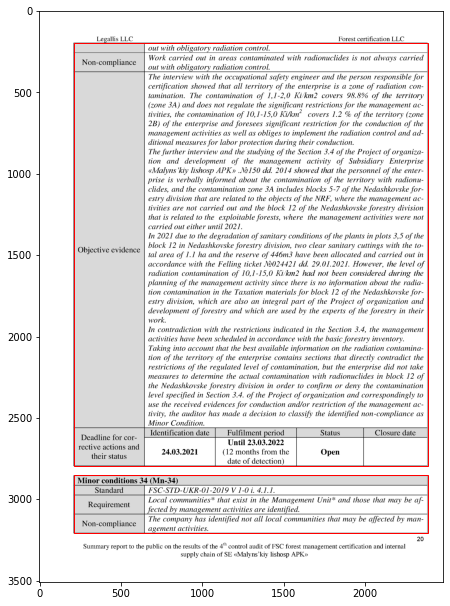

In [88]:
_p = camelot.plot(tables[0], kind='contour')
_p.set_size_inches(18.5, 10.5)
_p.show()


In [89]:
top_page  = round(tables[0].cells[0][0].y2,0)
bottom_page = round(tables[-1].cells[-1][-1].y1, 0)

top_page, bottom_page

(795.0, 72.0)

## Извлечение таблиц

При извлечении таблиц могут возникнуть следующие сложности

- Разрыв таблицы по страницам (первая часть таблицы на одной странице, вторая -- на следующей)
- Не всегда camelot распознает таблицу.

Для решения этих вопросов нужно решить и рассмотреть такие задачи
- определение полноты таблицы:
  - кол-во столбцов
  - кол-во рядов
  - наличие основных атрибутов:
    - заголовок `'Minor condition'`
    - поле `'Standard'`
    - поле `'Deadline for cor-\nrective actions and \ntheir status'`
    - поле `'Identification date'`
- Если таблица на полная, то это верх таблицы или ее низ:
  - Для верха таблицы выяснить:
    - заголовок `'Minor condition'`
    - поле `'Standard'` **Не уверен**.
    - Определить есть ли заголовок у последнего рядка таблицы, или там просто текст.
  - Для низа таблицы выяснить:
    - поле `'Deadline for cor-\nrective actions and \ntheir status'`
    - поле `'Identification date'`
    - Определить есть ли заголовок у первого рядка таблицы, или там просто текст.
- Таблица наверху или внизу (ее край рядом с верхом\низом страницы).
- Склейка разорванных таблиц
- Распознавание нераспознанных таблиц. Я считаю, что это верхние части таблиц, которые обрезались страницей. Для решения этого нам поможет прошлый пункт, если прошлая таблица не находится внизу, а следующая таблица неполная (низ таблицы), то значит мы пропустили верхнюю часть таблицы.
  - Перевод распознанной таблицы в приличный вид (склейка строк)

### Определение полноты таблицы

In [90]:
tables = camelot.read_pdf(file, pages = '19')
tables


<TableList n=1>

/tmp/ipykernel_10569/1382988782.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  _p.show()


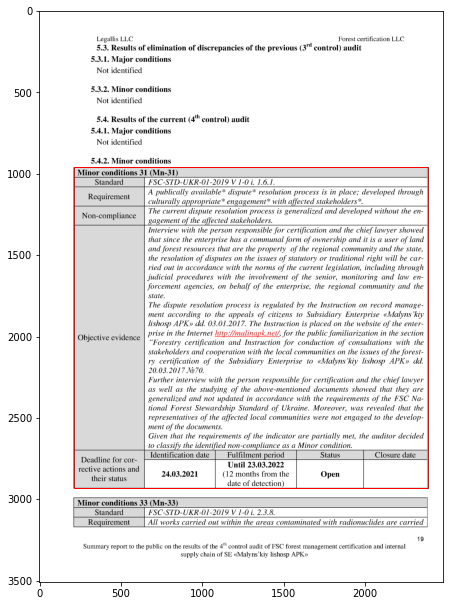

In [91]:
_p = camelot.plot(tables[0], kind='contour')
_p.set_size_inches(18.5, 10.5)
_p.show()

Видим тут полную таблицу, ее и будем брать за пример.

In [92]:
tables[0].df

,0,1,2,3,4
0,Minor conditions 31 (Mn-31),,,,
1,Standard,FSC-STD-UKR-01-2019 V 1-0 i. 1.6.1.,,,
2,Requirement,A publically available* dispute* resolution pr...,,,
3,Non-compliance,The current dispute resolution process is gene...,,,
4,Objective evidence,Interview with the person responsible for cert...,,,
5,Deadline for cor-\nrective actions and \ntheir...,Identification date,Fulfilment period,Status,Closure date
6,,24.03.2021,Until 23.03.2022 \n(12 months from the \ndate ...,Open,


In [93]:
# размер полной таблицы
tables[0].df.shape

(7, 5)

In [104]:
def check_shape(df)-> bool:
    '''
        Check shape of table (dataframe)
    '''
    return df.shape == (7,5)

In [105]:
check_shape(tables[0].df)

True

In [106]:
TITLE = 'Minor conditions'

def check_title(df)-> bool:
    """
    Check if title is in our table (dataframe)
    """
    return TITLE in df[0][0]

In [107]:
check_title(tables[0].df)

True

In [127]:
# атрибуты верха таблицы
TOP_ATTR = ['Standard']
# атрибуты низа таблицы
BOTTOM_ATTR = ['Deadline for cor-\nrective actions and \ntheir status', 'Identification date']
# главные атрибуты таблицы
MAIN_ATTR = top_attr + bottom_attr

def check_attributes(df, attr: list)-> bool:
    """
    Check that table (dataframe) has all attributes from list attr
    function check only that table has this attrubutes, don't check their places
    """
    res = []
    for _attr in attr:
        res.append((df == _attr).values.sum())

    return np.all(np.array(res))      


In [128]:
check_attributes(tables[0].df, MAIN_ATTR)

True

In [150]:
def is_full_table(df) -> bool:
    """
    Check that table is full.
    """
    return check_shape(df) and \
        check_title(df) and \
        check_attributes(df, MAIN_ATTR)

In [151]:
is_full_table(tables[0].df)

True

### Если таблица на полная, то это верх таблицы или ее низ

In [152]:
def is_top_table(df)-> bool:
    """
    Check that table has top attributes and title
    """
    return check_title(df) and\
         check_attributes(df, TOP_ATTR)

In [153]:
is_top_table(tables[0].df)

True

In [154]:
def table_has_last_attribute(df)-> bool:
    """
    Check that table in last row has attribute (zero column), not only text
    """
    shape = df.shape
    return bool(df[0][shape[0]-1])

Как видим полная таблица не имеет последнего атрибута, но это нормально. Мы не будем проверять полные таблицы на наличие последнего атрибута. Эта проверка нужна только для неполных таблиц, которые нужно состыковать с их отсальной частью на другой странице.

In [155]:
table_has_last_attribute(tables[0].df)

False

In [156]:
def is_bottom_table(df)-> bool:
    """
    Check that table has bottom attributes
    """
    return check_title(df) and\
         check_attributes(df, BOTTOM_ATTR)

In [157]:
is_bottom_table(tables[0].df)

True

In [158]:
def table_has_first_attribute(df)-> bool:
    """
    Check that table in first row has attribute (zero column), not only text
    """
    # shape = df.shape
    return bool(df[0][0])

In [159]:
table_has_first_attribute(tables[0].df)

True